In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.layers import Input,Dense, Flatten, Dropout, SimpleRNN, LSTM, GRU, Bidirectional
from statsmodels.tsa.seasonal import seasonal_decompose #לראות עונה ומגמה

In [2]:
!unzip climate.zip -d climate

Archive:  climate.zip
  inflating: climate/DailyDelhiClimateTest.csv  
  inflating: climate/DailyDelhiClimateTrain.csv  


In [21]:
test= pd.read_csv('climate/DailyDelhiClimateTest.csv')
train =pd.read_csv('climate/DailyDelhiClimateTrain.csv')

In [ ]:
#הכרות עם הנתונים
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
test.isna().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
train.isna().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [22]:
#המרה ל todate time עבור  train & test
train['date'] = pd.to_datetime(train['date'])

In [23]:
test['date']= pd.to_datetime(test['date'])

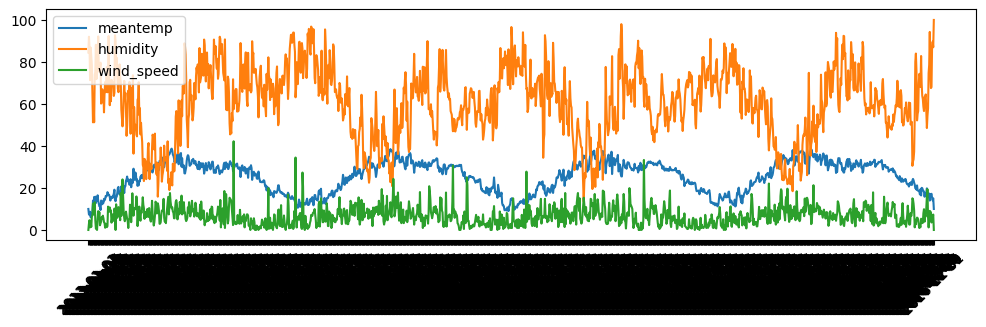

In [ ]:
#viz. the data from the train set
plt.figure(figsize=(12,3))
plt.plot(train['date'],train['meantemp'], label = 'meantemp')
plt.plot(train['date'], train['humidity'], label = 'humidity')
plt.plot(train['date'], train['wind_speed'], label = 'wind_speed')
plt.legend()
plt.xticks(rotation =90)
plt.show()

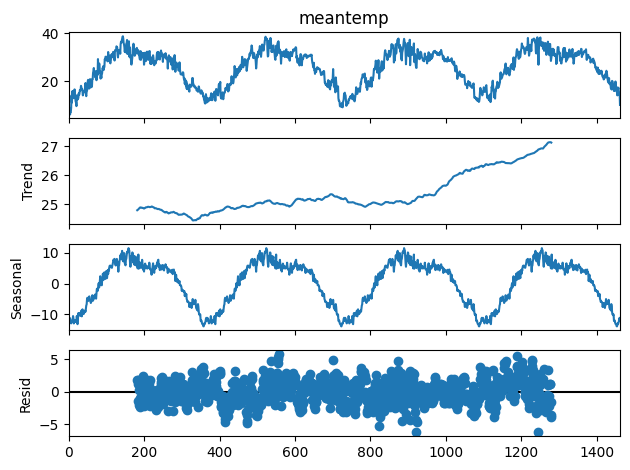

In [8]:
#עונה ומגמה
# ביצוע פירוק (additive כי העונתיות נראית קבועה יחסית)
result = seasonal_decompose(train['meantemp'], model='additive', period=365)#מחזור = 365 יום

# הצגת הגרפים
result.plot()
plt.show()


In [24]:
#set the index
train.set_index('date',inplace = True)
test.set_index('date',inplace = True)

In [14]:
train['meantemp']

,meantemp
date,
2013-01-01,-0.755459
2013-01-02,-0.914410
2013-01-03,-0.928675
2013-01-04,-0.836972
2013-01-05,-1.000000
...,...
2016-12-28,-0.314221
2016-12-29,-0.435226
2016-12-30,-0.505095


In [25]:
#הגדרת סט אימון וסט בדיקה  כך שיכללו רק את העמודות הבאות:
#[['meantemp','humidity',	'wind_speed']]
train = train[['meantemp','humidity',	'wind_speed']].copy()
test = test [['meantemp','humidity',	'wind_speed']].copy()

In [26]:
#סטנדרטיזציה
scaler = MinMaxScaler(feature_range=(-1,1))
#train
train['meantemp'] = scaler.fit_transform(train[['meantemp']])
train['humidity'] = scaler.fit_transform(train[['humidity']])
train['wind_speed'] = scaler.fit_transform(train[['wind_speed']])
#test
test['meantemp'] = scaler.fit_transform(test[['meantemp']])
test['humidity'] = scaler.fit_transform(test[['humidity']])
test['wind_speed'] = scaler.fit_transform(test[['wind_speed']])

In [11]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,-0.755459,0.641914,-1.000000,1015.666667
2013-01-02,-0.914410,0.815182,-0.858835,1017.800000
2013-01-03,-0.928675,0.699670,-0.780515,1018.666667
2013-01-04,-0.836972,0.337734,-0.941576,1017.166667
2013-01-05,-1.000000,0.695820,-0.824728,1016.500000


עבור ניתוח uni
```python
def windowed_dataset(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(1)
    return dataset


עבור ניתוח multi
```python
def windowed_dataset_multivariate(df, window_size, batch_size, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(df.values)  # מכניסים את כל העמודות
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # # כל ה-features עבור X, רק העמודה הראשונה (למשל טמפ') עבור Y
    dataset = dataset.map(lambda window: (window[:-1], window[-1, 0]))
    # # אם היינו רוצים לחזות את כל שלושת המשתנים
    #dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)
    return dataset


In [27]:
def windowed_dataset_multivariate(df, window_size, batch_size, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(df.values)  # מכניסים את כל העמודות
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # # כל ה-features עבור X, רק העמודה הראשונה (למשל טמפ') עבור Y
    dataset = dataset.map(lambda window: (window[:-1], window[-1, 0]))
    # # כל שלושת המשתנים
    #dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)
    return dataset


In [28]:
window_size = 90 #רצינו שנה 365 אבל אין לנו מספיק נתוני מבחן
batch_size = 16

train_dataset = windowed_dataset_multivariate(train, window_size, batch_size)
valid_dataset = windowed_dataset_multivariate(test, window_size, batch_size)

Epoch 1/10
     86/Unknown 6s 35ms/step - loss: 0.3334

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.3312 - val_loss: 0.0449
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0543 - val_loss: 0.0453
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0380 - val_loss: 0.2650
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0955 - val_loss: 2.0110
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0257 - val_loss: 0.3841
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0221 - val_loss: 0.0344
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0237 - val_loss: 0.0414
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0209 - val_loss: 0.0398
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0204 - val_loss: 0.0324
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0194 - val_loss: 0.0259
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


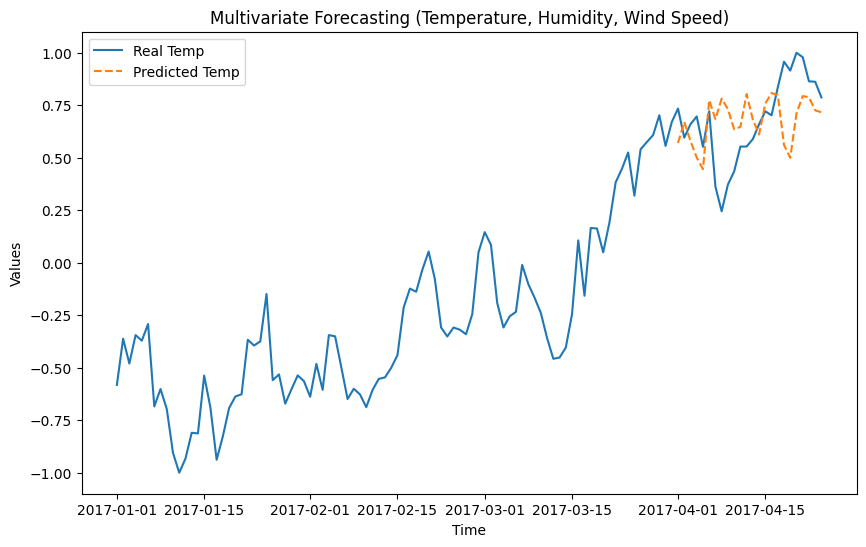

In [46]:
num_features = train.shape[1]  # מספר העמודות בסדרה

model = tf.keras.models.Sequential([
     Input(shape=(window_size, num_features)),
     SimpleRNN(64,return_sequences=True),
     SimpleRNN(64,return_sequences=True),
     tf.keras.layers.Dropout(0.2),
     SimpleRNN(64),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(32, activation="relu"),
     #tf.keras.layers.Dense(3) #ניבוי 3 ערכים
     tf.keras.layers.Dense(1),  # ניבוי ערך אחד (למשל טמפרטורה עתידית)


])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

##
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,#,
    callbacks=[early_stopping]
)
##
y_pred = model.predict(valid_dataset)

# מחזירים את הנתונים לסקאלה המקורית
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_pred = model.predict(valid_dataset)

# מחזירים את התחזיות לטווח המקורי של שלושת המשתנים
#y_pred = scaler.inverse_transform(y_pred)  # עכשיו `y_pred` בגודל (num_samples, 3)

# הצגת כל שלושת המשתנים בגרף
plt.figure(figsize=(10,6))
plt.plot(test.index, test[['meantemp']], label="Real Temp")
plt.plot(test.index[window_size:], y_pred[:,0], label="Predicted Temp", linestyle="dashed")

#plt.plot(test.index, test[['humidity']], label="Real Humidity", color="orange")
#plt.plot(test.index[window_size:], y_pred[:,1], label="Predicted Humidity", linestyle="dashed", color="orange")

#plt.plot(test.index, test[['wind_speed']], label="Real Wind Speed", color="green")
#plt.plot(test.index[window_size:], y_pred[:,2], label="Predicted Wind Speed", linestyle="dashed", color="green")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Multivariate Forecasting (Temperature, Humidity, Wind Speed)")
plt.show()


# # הצגת גרף תחזיות מול נתוני אמת
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,6))
# plt.plot(test.index[window_size:], test['meantemp'][window_size:], label="Real Data")
# plt.plot(test.index[window_size:], y_pred, label="Predictions", linestyle="dashed")
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Temperature")
# plt.title("Multivariate Time Series Forecast")
# plt.show()
